# Compare Methods in Optim.jl

In this notebook we will look into diffterent methods that are currently supported in `Optim.jl` and compare their performances in 5 parts: gradient-free, gradient-required, Hessian-required, linesearch and manifold.

The experiment is based on three 2-D problems: Rosenbrock function, Hosaki's and Himmelblau's function. These functions are pre-defined in package `OptimTestProblems`.

First let's show how these functions look like.

In [145]:
# Pkg.add("OptimTestProblems")
using OptimTestProblems
Rosenbrock = MultivariateProblems.UnconstrainedProblems.examples["Rosenbrock"]
Hosaki = MultivariateProblems.UnconstrainedProblems.examples["Hosaki"]
Himmelblau = MultivariateProblems.UnconstrainedProblems.examples["Himmelblau"]

OptimTestProblems.MultivariateProblems.OptimizationProblem{Void,Void,Float64,String,Void}("Himmelblau", OptimTestProblems.MultivariateProblems.UnconstrainedProblems.himmelblau, OptimTestProblems.MultivariateProblems.UnconstrainedProblems.himmelblau_gradient!, nothing, OptimTestProblems.MultivariateProblems.UnconstrainedProblems.himmelblau_hessian!, nothing, [2.0, 2.0], [3.0, 2.0], 0.0, true, true, nothing)

In [146]:
# Pkg.add("Plots")
using Plots
# plotlyjs()
pyplot()

Plots.PyPlotBackend()

In [147]:
function problem_contour(problem, range)
    x = y = range
    z = (x,y)->problem.f([x,y])
    contour(x, y, z, fill=true, color=:viridis, levels=300)
end

problem_contour (generic function with 1 method)

In [148]:
function problem_surface(problem, range)
    x = y = range
    z = (x,y)->problem.f([x,y])
    surface(x, y, Surface(z, x, y), alpha = 0.9, linealpha = 0.3, color=:viridis, legend = false)
end

problem_surface (generic function with 1 method)

**Rosenbrock's function** has the form

$$
f({\mathbf  {x}})=f(x_{1},x_{2})= [(1-x_1^2)+100(x_2-x_1^2)]^2
$$

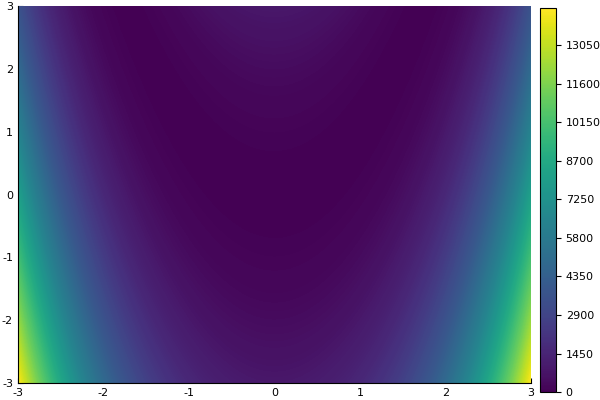

In [149]:
problem_contour(Rosenbrock, -3:0.1:3)

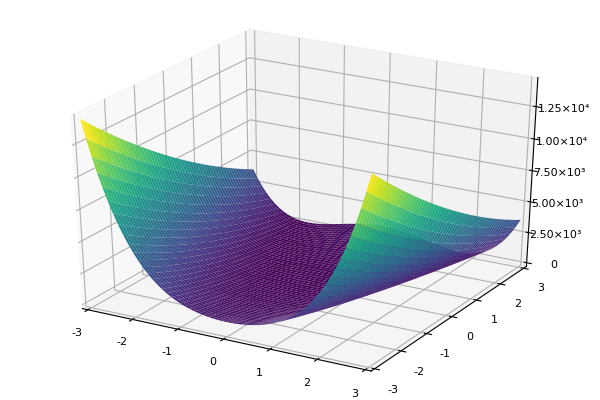

In [150]:
problem_surface(Rosenbrock, -3:0.1:3)

It has a banana-shape valley and two global minimum points at (-1,1) and (1,1).

**Hosaki's function** has the form

$$
f({\mathbf  {x}})=\left(1-8x_1+7x^2_1-\frac{7}{3}x^3_1+\frac{1}{4}x^4_1\right)x^2_2e^{-x_2}
$$

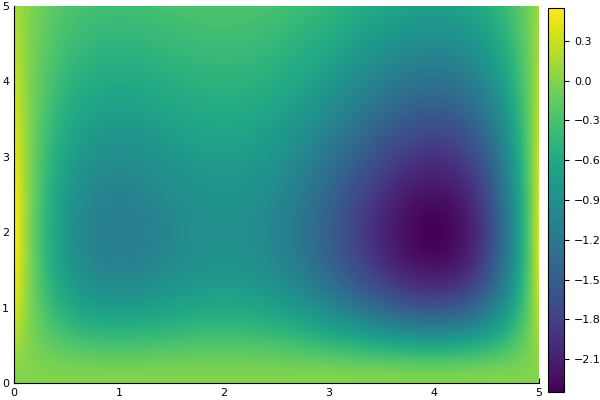

In [151]:
problem_contour(Hosaki, 0:0.1:5)

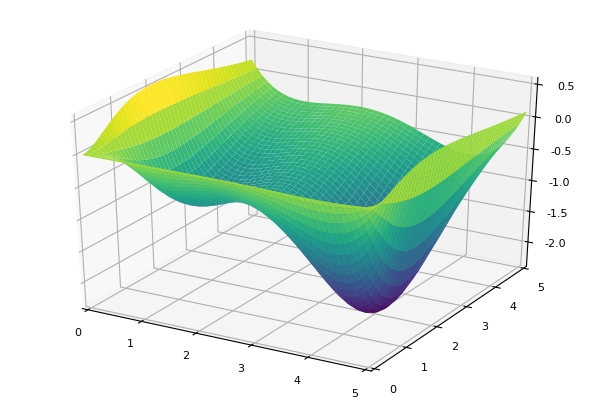

In [152]:
problem_surface(Hosaki, 0:0.1:5)

It has a global minimum point at (4,2). Notice that it also has another local minimum at (1, 2).

**Himmelblau's function** has the form

$$
f({\mathbf  {x}})=\left(x_1+x^2_2-7\right)^2+\left(x^2_1+x_2-11\right)^2
$$

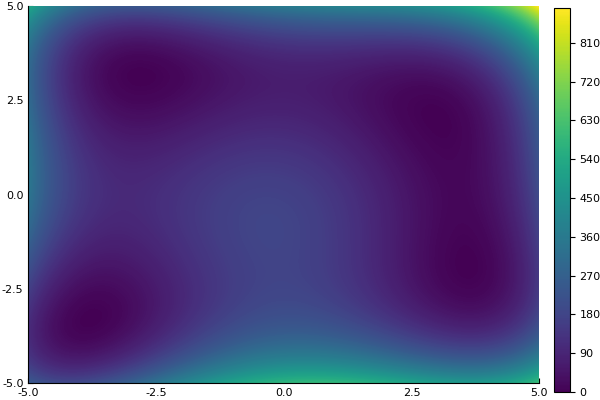

In [153]:
problem_contour(Himmelblau, -5:0.1:5)

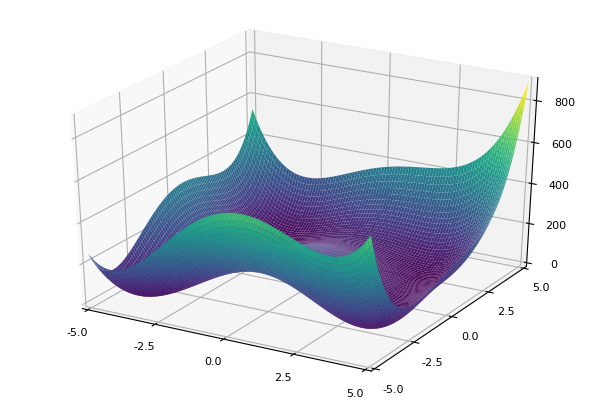

In [154]:
problem_surface(Himmelblau, -5:0.1:5)

It has four global minimum points at (3,2), (3.584428340330,−1.848126526964), (−3.779310253378,−3.283185991286) and (−2.805118086953,3.131312518250) with minimum value 0.

## Gradient Free

In [337]:
# Pkg.add("TimerOutputs")
using TimerOutputs

In [412]:
function gradient_free_contour(problem, range, initial_value)
    problem_contour(problem, range)
    
    @timeit to "Nelder Mead" begin
        nm_results = optimize(problem.f, initial_value, Optim.Options(store_trace = true, extended_trace = true))
    end
    
    nm_trace = [trace.metadata["centroid"] for trace in Optim.trace(nm_results)]
    plot!(getindex.(nm_trace, 1), getindex.(nm_trace, 2), label="Nelder Mead", shape = :circle)
    
    @timeit to "Simulated Annealing" begin
        sa_results = optimize(Rosenbrock.f, initial_value, SimulatedAnnealing(), Optim.Options(store_trace = true, extended_trace = true))
    end
    
    sa_trace = Optim.x_trace(results)
    plot!(getindex.(sa_trace, 1), getindex.(sa_trace, 2), label="Simulated Annealing", shape = :circle)
end

gradient_free_contour (generic function with 2 methods)

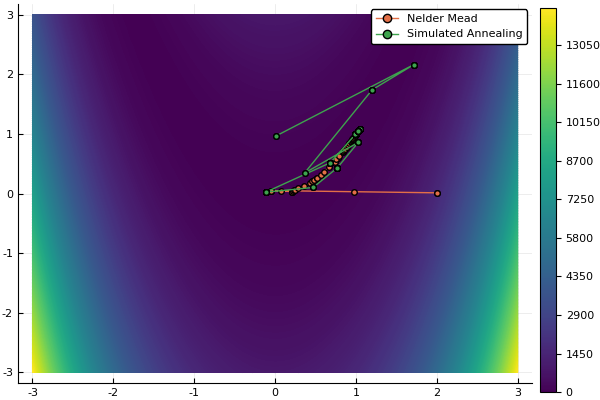

In [460]:
to = TimerOutput()
gradient_free_contour(Rosenbrock, -3:0.1:3, [2.0, 0.0])

In [358]:
show(to, allocations = true, compact = true)

 ─────────────────────────────────────────────────────────────
                                    Time         Allocations  
                               ──────────────   ──────────────
        Total measured:             1.58s          10.7MiB    

 Section               ncalls     time   %tot     alloc   %tot
 ─────────────────────────────────────────────────────────────
 Simulated Annealing        1    702μs  84.4%    784KiB  91.3%
 Nelder Mead                1    129μs  15.6%   74.7KiB  8.70%
 ─────────────────────────────────────────────────────────────

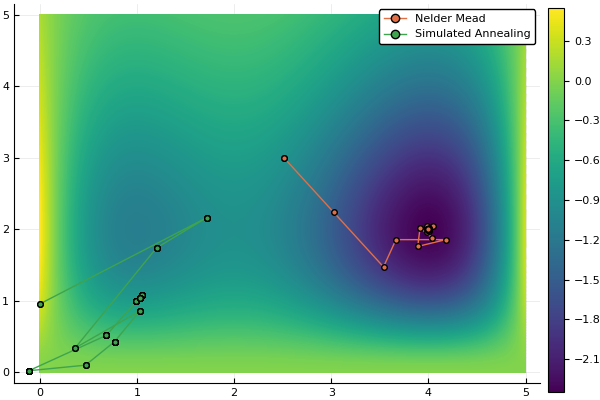

In [457]:
to = TimerOutput()
gradient_free_contour(Hosaki, 0:0.1:5, [2.0, 3.0])

In [360]:
show(to, allocations = true, compact = true)

 ─────────────────────────────────────────────────────────────
                                    Time         Allocations  
                               ──────────────   ──────────────
        Total measured:             2.46s          17.6MiB    

 Section               ncalls     time   %tot     alloc   %tot
 ─────────────────────────────────────────────────────────────
 Simulated Annealing        2   2.05ms  86.3%   1.53MiB  92.5%
 Nelder Mead                2    325μs  13.7%    128KiB  7.52%
 ─────────────────────────────────────────────────────────────

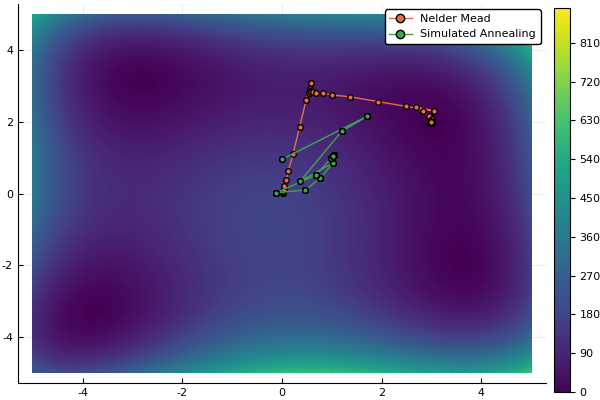

In [458]:
to = TimerOutput()
gradient_free_contour(Himmelblau, -5:0.1:5, [0.0, 0.0])

In [362]:
show(to, allocations = true, compact = true)

 ─────────────────────────────────────────────────────────────
                                    Time         Allocations  
                               ──────────────   ──────────────
        Total measured:             5.23s          28.0MiB    

 Section               ncalls     time   %tot     alloc   %tot
 ─────────────────────────────────────────────────────────────
 Simulated Annealing        3   3.39ms  85.2%   2.30MiB  92.5%
 Nelder Mead                3    590μs  14.8%    192KiB  7.54%
 ─────────────────────────────────────────────────────────────

From tests above, we can see that Simulated Annealing method did't go to the minimum point except in Rosenbrock's function and cost more time. Nelder Mead succeed to find the minimum in all cases.

## Gradient Required

In [469]:
function nm_plot!(problem, initial_value)
    @timeit to "Nelder Mead" begin
        nm_results = optimize(problem.f, initial_value, Optim.Options(store_trace = true, extended_trace = true))
    end
    nm_trace = [trace.metadata["centroid"] for trace in Optim.trace(nm_results)]
    plot!(getindex.(nm_trace, 1), getindex.(nm_trace, 2), label="Nelder Mead", shape = :circle, markersize = 2)
end

nm_plot! (generic function with 2 methods)

In [470]:
function gradient_plot!(problem, method, method_name, initial_value)
    @timeit to method_name begin
        results = optimize(problem.f, problem.g!, initial_value, method, Optim.Options(store_trace = true, extended_trace = true))
    end
    trace = Optim.x_trace(results)
    plot!(getindex.(trace, 1), getindex.(trace, 2), label=method_name, shape = :circle, markersize = 2)
end

gradient_plot! (generic function with 1 method)

In [471]:
function gradient_contour(problem, range, initial_value)
    problem_contour(problem, range)
    gradient_plot!(problem, LBFGS(), "L-BFGS", initial_value)
    gradient_plot!(problem, BFGS(), "BFGS", initial_value)
    gradient_plot!(problem, ConjugateGradient(), "Conjugate Gradient Descent", initial_value)
    gradient_plot!(problem, GradientDescent(), "Gradient Descent", initial_value)
end

gradient_contour (generic function with 3 methods)

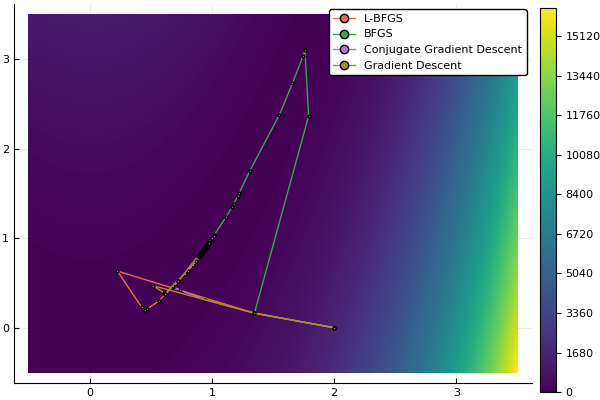

In [472]:
to = TimerOutput()
gradient_contour(Rosenbrock, -0.5:0.1:3.5, [2.0, 0.0])

In [473]:
show(to, allocations = true, compact = true)

 ────────────────────────────────────────────────────────────────────
                                           Time         Allocations  
                                      ──────────────   ──────────────
            Total measured:                1.48s          8.18MiB    

 Section                      ncalls     time   %tot     alloc   %tot
 ────────────────────────────────────────────────────────────────────
 Gradient Descent                  1   7.22ms  91.9%   1.76MiB  93.6%
 L-BFGS                            1    235μs  2.99%   40.2KiB  2.08%
 BFGS                              1    208μs  2.65%   43.3KiB  2.25%
 Conjugate Gradient Descent        1    192μs  2.45%   40.8KiB  2.12%
 ────────────────────────────────────────────────────────────────────

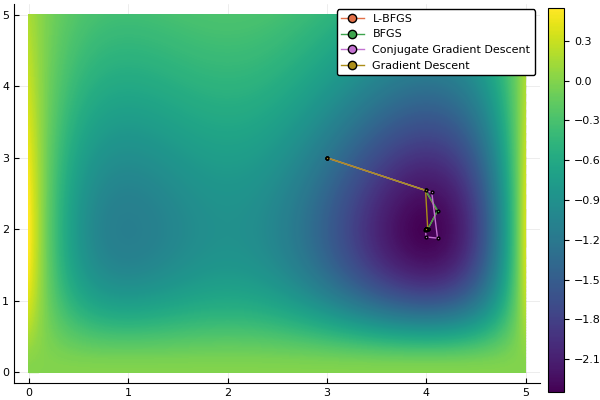

In [474]:
to = TimerOutput()
gradient_contour(Hosaki, 0:0.1:5, [3.0, 3.0])

In [475]:
show(to, allocations = true, compact = true)

 ────────────────────────────────────────────────────────────────────
                                           Time         Allocations  
                                      ──────────────   ──────────────
            Total measured:                2.57s          6.05MiB    

 Section                      ncalls     time   %tot     alloc   %tot
 ────────────────────────────────────────────────────────────────────
 Gradient Descent                  1    351μs  43.0%   34.3KiB  36.6%
 L-BFGS                            1    198μs  24.3%   17.3KiB  18.4%
 Conjugate Gradient Descent        1    160μs  19.7%   27.0KiB  28.8%
 BFGS                              1    106μs  13.0%   15.2KiB  16.2%
 ────────────────────────────────────────────────────────────────────

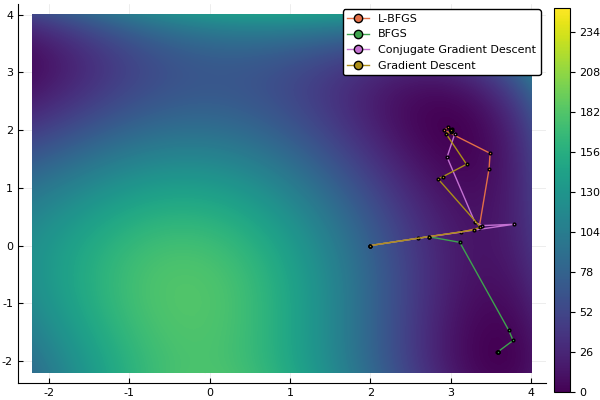

In [476]:
to = TimerOutput()
gradient_contour(Himmelblau, -2.2:0.1:4, [2.0, 0.0])

In [454]:
show(to, allocations = true, compact = true)

 ────────────────────────────────────────────────────────────────────
                                           Time         Allocations  
                                      ──────────────   ──────────────
            Total measured:                1.03s          7.68MiB    

 Section                      ncalls     time   %tot     alloc   %tot
 ────────────────────────────────────────────────────────────────────
 Gradient Descent                  1    220μs  29.4%   71.1KiB  33.2%
 L-BFGS                            1    166μs  22.1%   29.5KiB  13.8%
 Conjugate Gradient Descent        1    141μs  18.8%   25.1KiB  11.7%
 Nelder Mead                       1    118μs  15.8%   64.1KiB  29.9%
 BFGS                              1    104μs  13.9%   24.4KiB  11.4%
 ────────────────────────────────────────────────────────────────────

All method went to the minimum point with different paths. Note that Gradient Descent costs most time because it only uses gradient information.

# Gradient Required and Gradient Free

In [477]:
function nm_plot!(problem, initial_value)
    @timeit to "Nelder Mead" begin
        nm_results = optimize(problem.f, initial_value, Optim.Options(store_trace = true, extended_trace = true))
    end
    nm_trace = [trace.metadata["centroid"] for trace in Optim.trace(nm_results)]
    plot!(getindex.(nm_trace, 1), getindex.(nm_trace, 2), label="Nelder Mead", shape = :circle, markersize = 2)
end

nm_plot! (generic function with 2 methods)

In [481]:
function gradient_nm_contour(problem, range, initial_value)
    problem_contour(problem, range)
    nm_plot!(problem, initial_value)
    gradient_plot!(problem, ConjugateGradient(), "Conjugate Gradient Descent", initial_value)
    gradient_plot!(problem, GradientDescent(), "Gradient Descent", initial_value)
end

gradient_nm_contour (generic function with 1 method)

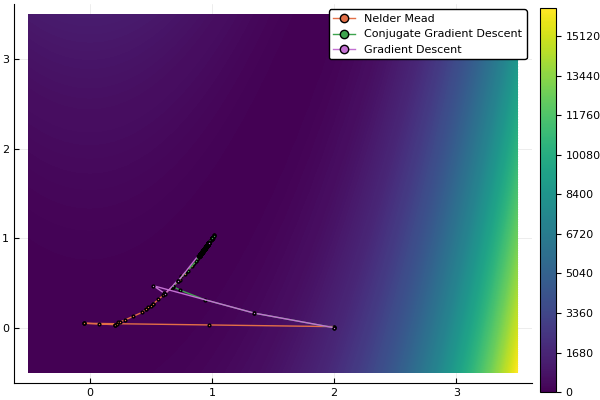

In [482]:
to = TimerOutput()
gradient_nm_contour(Rosenbrock, -0.5:0.1:3.5, [2.0, 0.0])

In [483]:
show(to, allocations = true, compact = true)

 ────────────────────────────────────────────────────────────────────
                                           Time         Allocations  
                                      ──────────────   ──────────────
            Total measured:                894ms          6.81MiB    

 Section                      ncalls     time   %tot     alloc   %tot
 ────────────────────────────────────────────────────────────────────
 Gradient Descent                  1   6.70ms  94.6%   1.76MiB  94.0%
 Nelder Mead                       1    204μs  2.88%   74.7KiB  3.90%
 Conjugate Gradient Descent        1    176μs  2.48%   40.8KiB  2.13%
 ────────────────────────────────────────────────────────────────────

Gradient-required method uses gradient information, thus it takes the steepest direction to the bottom while gradient-free method only "searches around" to find the best point. As we can see above, gradient-required methods take a shorter path. However, gradient-free method still costs least time.

# Hessian Required 

In [397]:
function hessian_plot!(problem, method, method_name, initial_value)
    @timeit to method_name begin
        results = optimize(problem.f, problem.g!, problem.h!, initial_value, method, Optim.Options(store_trace = true, extended_trace = true))
    end
    trace = Optim.x_trace(results)
    plot!(getindex.(trace, 1), getindex.(trace, 2), label=method_name, shape = :circle, markersize = 2)
end

hessian_plot! (generic function with 1 method)

In [398]:
function hessian_contour(problem, range, initial_value)
    problem_contour(problem, range)
    hessian_plot!(problem, Newton(), "Newton's Method", initial_value)
    hessian_plot!(problem, NewtonTrustRegion(), "Newton's Method With a Trust Region", initial_value)
end

hessian_contour (generic function with 2 methods)

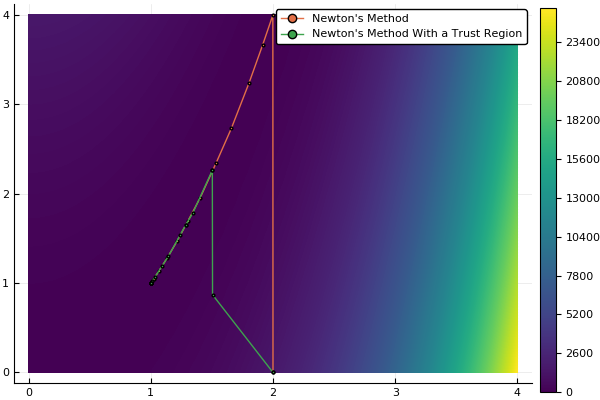

In [399]:
to = TimerOutput()
hessian_contour(Rosenbrock, 0:0.1:4, [2.0, 0.0])

In [400]:
show(to, allocations = true, compact = true)

 ─────────────────────────────────────────────────────────────────────────────
                                                    Time         Allocations  
                                               ──────────────   ──────────────
                Total measured:                     3.71s          5.32MiB    

 Section                               ncalls     time   %tot     alloc   %tot
 ─────────────────────────────────────────────────────────────────────────────
 Newton's Method With a Trust Region        1    322μs  59.4%   84.2KiB  63.4%
 Newton's Method                            1    220μs  40.6%   48.5KiB  36.6%
 ─────────────────────────────────────────────────────────────────────────────

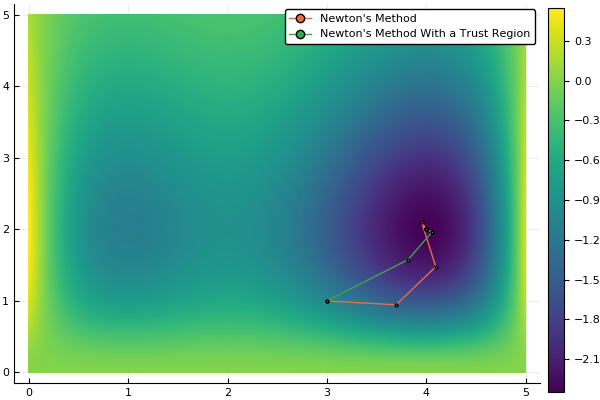

In [406]:
to = TimerOutput()
hessian_contour(Hosaki, 0:0.1:5, [3.0, 1.0])

In [407]:
show(to, allocations = true, compact = true)

 ─────────────────────────────────────────────────────────────────────────────
                                                    Time         Allocations  
                                               ──────────────   ──────────────
                Total measured:                     1.10s          5.44MiB    

 Section                               ncalls     time   %tot     alloc   %tot
 ─────────────────────────────────────────────────────────────────────────────
 Newton's Method With a Trust Region        1    179μs  53.9%   30.5KiB  58.8%
 Newton's Method                            1    153μs  46.1%   21.3KiB  41.2%
 ─────────────────────────────────────────────────────────────────────────────

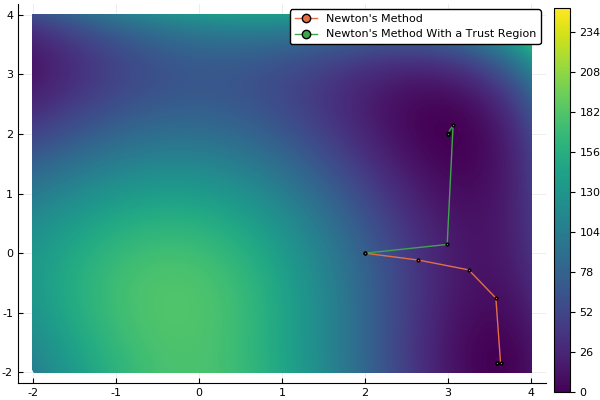

In [410]:
to = TimerOutput()
hessian_contour(Himmelblau, -2:0.1:4, [2.0, 0.0])

In [411]:
show(to, allocations = true, compact = true)

 ─────────────────────────────────────────────────────────────────────────────
                                                    Time         Allocations  
                                               ──────────────   ──────────────
                Total measured:                     983ms          6.14MiB    

 Section                               ncalls     time   %tot     alloc   %tot
 ─────────────────────────────────────────────────────────────────────────────
 Newton's Method With a Trust Region        1    184μs  53.8%   37.3KiB  58.6%
 Newton's Method                            1    158μs  46.2%   26.4KiB  41.4%
 ─────────────────────────────────────────────────────────────────────────────

As shown above, both method succeed to find the minimum point through different paths. Newton's Method With a Trust Region takes a shorter path since it puts some restrictions.

# Local Minimum Trap
A common issue in gradient-required and Hessian-required optimization is "local minimum trap". Borrowing from Andrew Ng's lecture slides, we can see that at the saddle point (or at other local minimums) where the derivative is zero, the result gets stuck at the local minimum or saddle point rather than the global minimum.

![saddle point](https://cdn-images-1.medium.com/max/2000/1*X6CH4TCPIF5byOWPIn8LGw.png)

In this section we will test how different method responses to the local minimum trap.

In [466]:
function saddle_contour(problem, range, initial_value)
    problem_contour(problem, range)
    nm_plot!(problem, initial_value)
    hessian_plot!(problem, Newton(), "Newton's Method", initial_value)
    hessian_plot!(problem, NewtonTrustRegion(), "Newton's Method With a Trust Region", initial_value)
    gradient_plot!(problem, LBFGS(), "L-BFGS", initial_value)
    gradient_plot!(problem, BFGS(), "BFGS", initial_value)
    gradient_plot!(problem, ConjugateGradient(), "Conjugate Gradient Descent", initial_value)
    gradient_plot!(problem, GradientDescent(), "Gradient Descent", initial_value)
end

saddle_contour (generic function with 1 method)

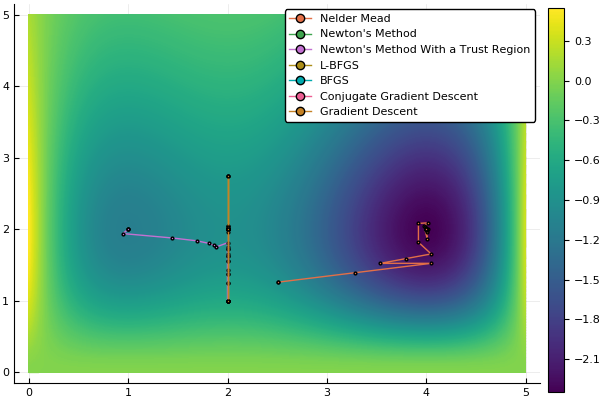

In [467]:
saddle_contour(Hosaki, 0:0.1:5, [2.0, 1.0])

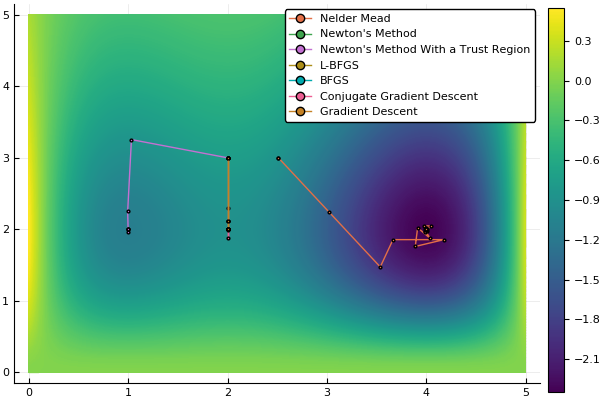

In [468]:
saddle_contour(Hosaki, 0:0.1:5, [2.0, 3.0])

We can see only Nelder Mead method succeed to find the global minimum in this case. Newton's Method With a Trust Region escaped the saddle point but went to another local minimum. Other method stuck at the saddle point.